<center><h1 style="font-size:35px; font-family: 'Calisto MT'; letter-spacing: 0.1em; background-color: RGB(255, 165, 0);"> <br> Statistiques Exploratoire Spatiales(avec R) <br></h1></center>
<center><h3 style="font-size:25px; font-family: 'Calisto MT'; letter-spacing: 0.1em; background-color: RGB(51,165,182);"> Réalisé par le Groupe R </h3></center>
ENSAE 2024 : ISE1 CL <right> <br> Professeur : M. Aboubacer HEMA <br> Etudiants : COULIBALY Khadidiatou, DIENG Samba, ONANENA AMANA Jeanne De La Flèche, NDONG Tamsir </right>

<center><h2 style="font-size:28px; font-family: 'Calisto MT'; letter-spacing: 0.1em;"> TP5 </h2></center>

________________________

<h2 style="text-align:center; background-color:RGB(51,165,182);font-size:45px;font-family:Algerian">Les préliminaires...</h2>

<h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;"> CONSIGNE </h1>

1. **Importer et visualiser le raster population**
2. **Calculer le nombre de personnes par admin et exporter sous format .csv**
3. **Ramener la taille des pixels à 5km**
4. **Visualiser le nouveau raster de la population**
5. **Calculer un nouveau raster d'enfants de 0 à 12ans (O.1%)**
6. **Créer 3 nouveaux rasters binarisés**
7. **Multiplier chacun d'eux par celui de la population**
8. **Calculer nombre d'enfants atteints de la malaria par admin et exporter**
9. **Quel est le taux d'enfants atteints de malaria par admin ?**

<h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  Importation des packages </h1>

In [1]:
suppressMessages({

library(stars)       # Manipulation des données raster et vecteur
library(sf)          # Manipulation des objets géospatiaux
library(ggplot2)     # Visualisations graphiques
library(ggspatial)   # Ajout d'éléments cartographiques (flèche du nord, échelle)
library(raster)      # Manipulation des données raster
library(cowplot)     # Extraction et affichage de la légende
library(leaflet)     # Création de cartes interactives avec limites administratives
library(viridis)     # Palette de couleurs viridis
#library(units)       # Gestion des unités dans les données géospatiales
library(dplyr)       # Gestion des bases de données
library(exactextractr) #Une sorte de "reducer"

})

<h2 style="text-align:center; background-color:RGB(51,165,182);font-size:45px;font-family:Algerian"> Le TP proprement dit</h2>

<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  1. Importation et visualisation </h2>

In [2]:
# Setting the work directory
setwd("C:/Users/DELL/Documents/ISEP3_2025/Stats_spatiale/Statistique-Exploratoire-Spatiale/TP5/Groupe - R/data_CMR")

In [3]:
suppressMessages({

cameroun<- st_read("cmr_admbnda_adm0_inc_20180104.shp", quiet = TRUE)
region <- st_read("cmr_admbnda_adm1_inc_20180104.shp", quiet = TRUE)
departement <- st_read("cmr_admbnda_adm2_inc_20180104.shp", quiet = TRUE)
arrondissement <- st_read("cmr_admbnda_adm3_inc_20180104.shp", quiet = TRUE)

# Charger les rasters en faisant un crop et un mask
malaria_2022_CMR <-raster("Indic2022_taux_maliaria_3niveaux.tif") %>%
  crop(cameroun) %>%
  mask(cameroun)
    
taux_2022 <- raster("202406_Global_Pf_Parasite_Rate_CMR_2022.tiff") %>%
  crop(cameroun) %>%
  mask(cameroun)
    
pop <- raster("CMR_population_v1_0_gridded.tif") %>%
  crop(cameroun) %>%
  mask(cameroun)

})

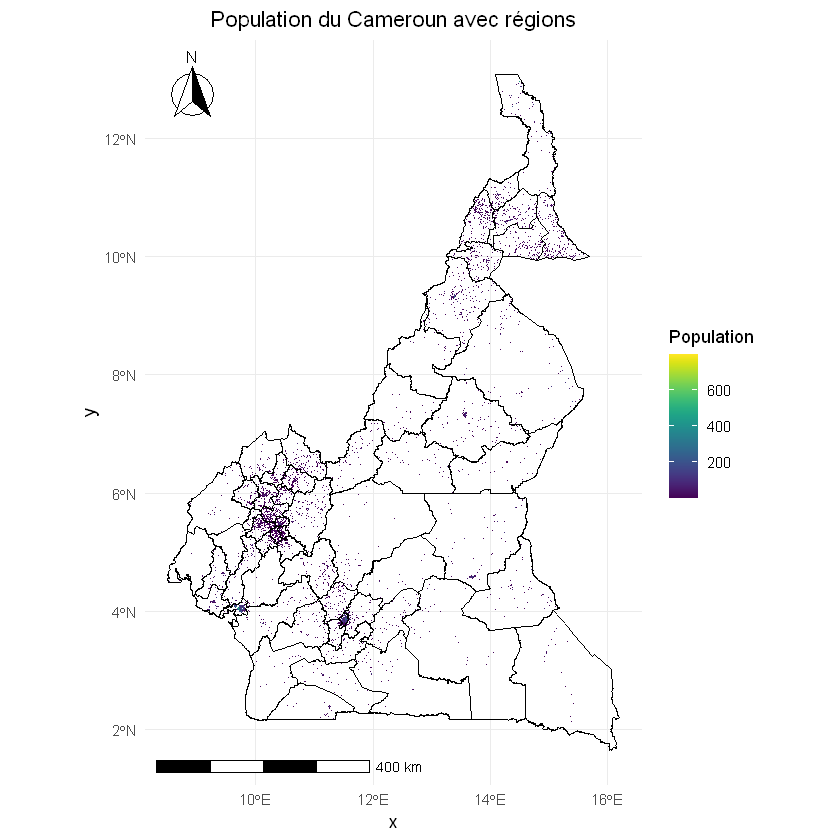

In [4]:
pop_df <- as.data.frame(rasterToPoints(pop), stringsAsFactors = FALSE)
colnames(pop_df) <- c("x", "y", "value")
ggplot() +
  geom_tile(data = pop_df, aes(x = x, y = y, fill = value)) +
  geom_sf(data = departement, fill = NA, color = "black", size = 0.5) +  # Ajouter les contours des régions
  scale_fill_viridis(option = "viridis", na.value = "transparent") +
  labs(title = "Population du Cameroun avec départements",
       fill = "Population") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "right"
  )+ 
  annotation_north_arrow(location = "tl", which_north = "true", pad_x = unit(0.1, "in"), pad_y = unit(0.1, "in"), style = north_arrow_fancy_orienteering()) + 
  annotation_scale(location = "bl", width_hint = 0.5)

<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  2. Calcul du nombre de personnes par admin (0-3) et exportation sous format .csv </h2>

## Avant tout calcul, ajoutons des buffers à nos shapefiles

In [7]:
# On étend artificiellement notre shapefile du pays
cameroun_1 <- st_buffer(cameroun, dist = 5000)

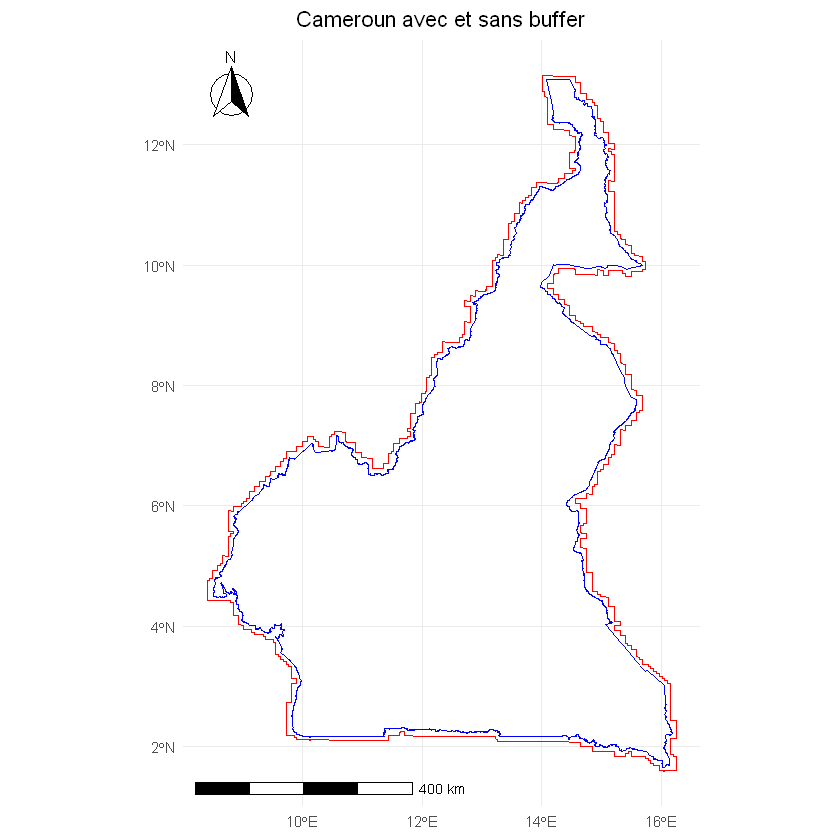

In [14]:
ggplot() +
  geom_sf(data = cameroun_1, fill= NA, color = "red", size = 0.5) +  # Ajout du shapefile "bufferisé"
  geom_sf(data = cameroun, fill= NA, color = "blue", size = 0.5) + # Ajout du shp orignal
  labs(title = "Cameroun avec et sans buffer") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "right"
  )+ 
  annotation_north_arrow(location = "tl", which_north = "true", pad_x = unit(0.1, "in"), pad_y = unit(0.1, "in"), style = north_arrow_fancy_orienteering()) + 
  annotation_scale(location = "bl", width_hint = 0.5)


____________________

In [239]:
# On va maintenant faire une "intersection"

region <-  suppressWarnings(st_intersection(region, cameroun_1))
departement <- suppressWarnings(st_intersection(departement, cameroun_1))
arrondissement <- suppressWarnings(st_intersection(arrondissement, cameroun_1))
                                
 # Il semble que cela redonne les mêmes shp..

### Le principe de l'intersection

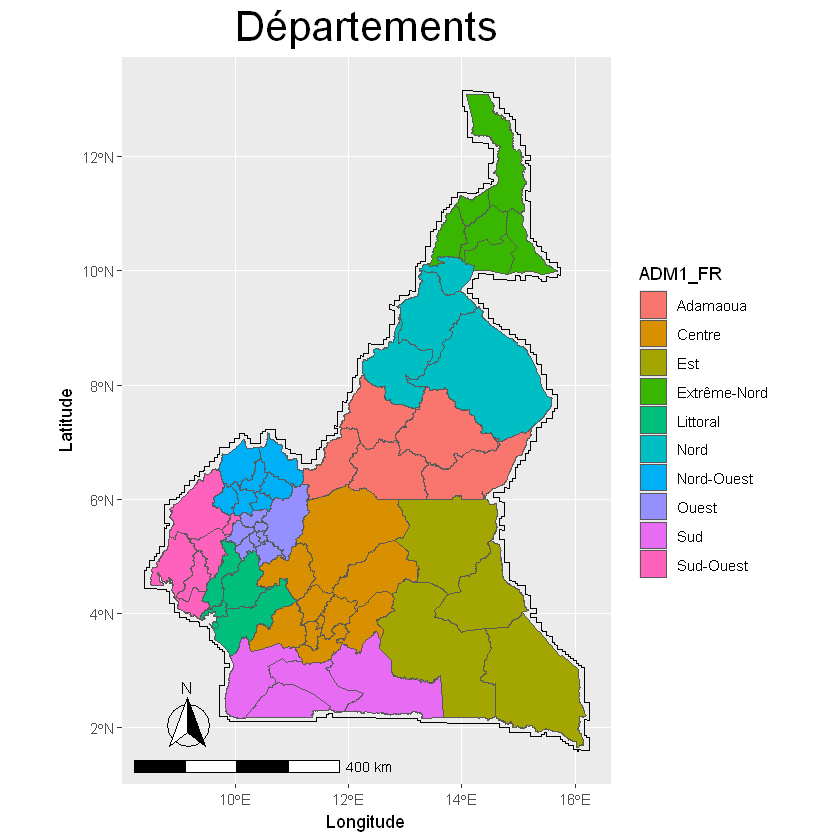

In [19]:
# Visualisons
ggplot() + 
  geom_sf(data = departement, mapping = aes(fill = ADM1_FR)) + 
  geom_sf(data = cameroun_1, fill= NA, color = "black", size = 0.5) + # Ajout du shp orignal
  ggtitle("Départements") +  # Titre de la carte
  theme(plot.title = element_text(hjust = 0.5, size = 25)) + 
  xlab("Longitude") + 
  ylab("Latitude") + 
  annotation_north_arrow(location = "bl", which_north = "true", pad_x = unit(0.25, "in"), pad_y = unit(0.25, "in"), style = north_arrow_fancy_orienteering()) + 
  annotation_scale(location = "bl", width_hint = 0.5)

In [232]:
# Calculer la population pour chaque niveau administratif
pop_admin0 <- exact_extract(pop, cameroun, fun = "sum", progress = FALSE)
cameroun$population <- pop_admin0

pop_cameroun <- cameroun %>%
  st_drop_geometry() %>%       
  select(ADM0_FR, population) 


pop_cameroun <- data.frame(pop_cameroun)
pop_cameroun

,ADM0_FR,population
,<chr>,<dbl>
1,Cameroun (le),28611876


In [233]:
pop_admin1 <- exact_extract(pop, region, fun = "sum", progress = FALSE)
region$population <- pop_admin1

pop_region <- region %>%
  st_drop_geometry() %>%      
  select(ADM1_FR, population)  

pop_region <- data.frame(pop_region)
head(pop_region, 5)

,ADM1_FR,population
,<chr>,<dbl>
1,Adamaoua,1649247
2,Centre,5207611
3,Est,1508061
4,Extrême-Nord,5346909
5,Littoral,4456166


In [234]:
pop_admin2 <- exact_extract(pop, departement, fun = "sum", progress = FALSE)
departement$population <- pop_admin2

pop_departement <- departement %>%
  st_drop_geometry() %>%      
  select(ADM2_FR, population)   

pop_departement <- data.frame(pop_departement)
head(pop_departement, 5)

,ADM2_FR,population
,<chr>,<dbl>
1,Bamboutos,385835.3
2,Bénoué,1660537.5
3,Boumba-et-Ngoko,157055.0
4,Boyo,135210.3
5,Bui,261324.8


In [235]:
pop_admin3 <- exact_extract(pop, arrondissement, fun = "sum", progress = FALSE)
arrondissement$population <- pop_admin3

pop_arrondissement <- arrondissement %>%
  st_drop_geometry() %>%       
  select(ADM3_FR, population)  

pop_arrondissement <- data.frame(pop_arrondissement)
head(pop_arrondissement, 5)

,ADM3_FR,population
,<chr>,<dbl>
1,Abong-Mbang,40934.281
2,Afanloum,3442.716
3,Ako,33204.461
4,Akoeman,8750.636
5,Akom 2,13346.139


In [211]:
# Vérifications
t <- data.frame(sum_region = sum(pop_region$population),
sum_departements=sum(pop_departement$population),
sum_arrondissements=sum(pop_arrondissement$population))
t

## Les résultats sont égaux A DES VIRGULES PRES !

sum_region,sum_departements,sum_arrondissements
<dbl>,<dbl>,<dbl>
28611876,28611876,28611876


In [ ]:
output_folder <- "Outputs/"
dir.create(output_folder, showWarnings = FALSE) 

# Exporter chaque data frame sous format CSV
write.csv(pop_cameroun, file.path(output_folder, "pop_cameroun.csv"), row.names = FALSE)
write.csv(pop_region, file.path(output_folder, "pop_region.csv"), row.names = FALSE)
write.csv(pop_departement, file.path(output_folder, "pop_departement.csv"), row.names = FALSE)
write.csv(pop_arondissement, file.path(output_folder, "pop_arondissement.csv"), row.names = FALSE)

# Messages de confirmation
cat("Les fichiers CSV ont été exportés dans le dossier :", output_folder)

<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  3. Résolution à 5km par aggrégation (somme)</h2>

In [16]:
## Voyons la taille des pixels en dergrés
res(pop)

[1] 0.0008333333 0.0008333333

In [6]:
pop_newResw <- aggregate(pop, fact = 50, fun = sum, 
                         filename = "CMR_population_aggregated_5km.tif", 
                         overwrite = TRUE)

# facteur d'agrégation : 5000m/100m
# Agrégation des valeurs : somme des valeurs des pixels ('sum')

In [30]:
## Metadonnées du nouveau raster
pop_newResw

class      : RasterLayer 
dimensions : 274, 183, 50142  (nrow, ncol, ncell)
resolution : 0.04166667, 0.04166667  (x, y)
extent     : 8.49875, 16.12375, 1.627084, 13.04375  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : CMR_population_aggregated_5km.tif 
names      : CMR_population_aggregated_5km 
values     : 0.9970116, 529241.4  (min, max)


<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  4. Visualisation du nouveau raster </h2>

In [215]:
# Vérifications
pop_a <- exact_extract(pop_newResw %>%
  crop(cameroun_1) %>%
  mask(cameroun_1), cameroun_1, fun = "sum", progress = FALSE)

pop_a

[1] 28614930

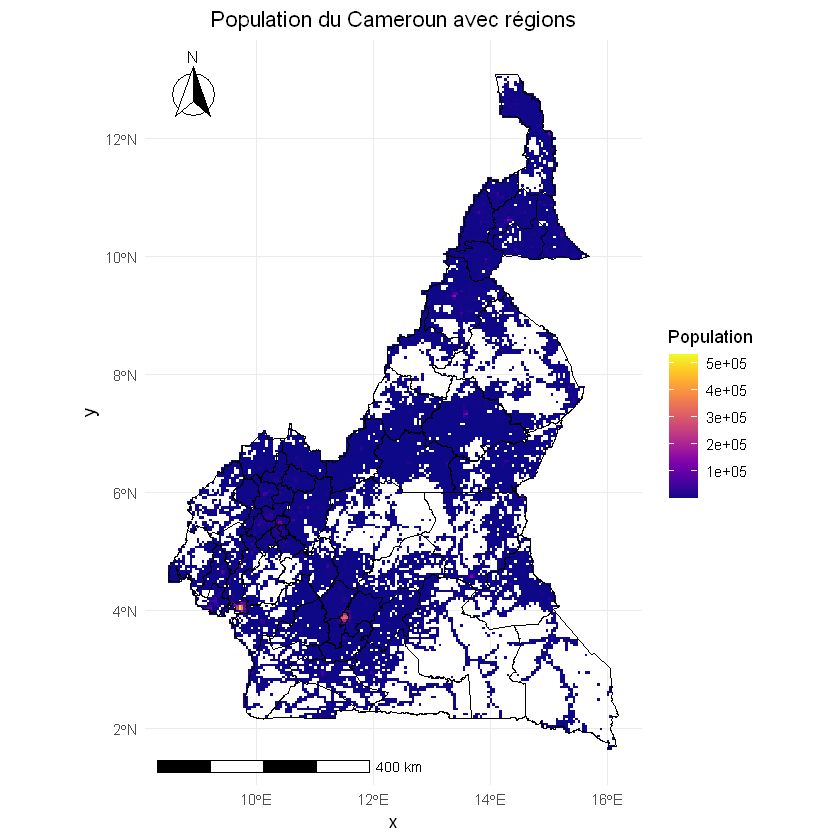

In [36]:
pop_df <- as.data.frame(rasterToPoints(pop_newResw), stringsAsFactors = FALSE)
colnames(pop_df) <- c("x", "y", "value")
ggplot() +
  geom_tile(data = pop_df, aes(x = x, y = y, fill = value)) +
  geom_sf(data = departement, fill = NA, color = "black", size = 0.5) +  # Ajouter les contours des régions
  scale_fill_viridis(option = "plasma", na.value = "transparent") +
  labs(title = "Population du Cameroun avec départements",
       fill = "Population") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "right"
  )+ 
  annotation_north_arrow(location = "tl", which_north = "true", pad_x = unit(0.1, "in"), pad_y = unit(0.1, "in"), style = north_arrow_fancy_orienteering()) + 
  annotation_scale(location = "bl", width_hint = 0.5)

<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  5. Raster des enfants de 0 à 12 ans (0.1% de la population) </h2>

In [32]:
# Multiplication
pop_child <- pop_newResw*0.001

In [216]:
pop_b <- exact_extract(pop_child %>%
  crop(cameroun_1) %>%
  mask(cameroun_1), cameroun_1, fun = "sum", progress = FALSE)

print('Vérifications')
pop_b
(pop_b/pop_a)*100

[1] "Vérifications"


[1] 28614.93

[1] 0.1

<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  6. Visualisation du nouveau raster </h2>

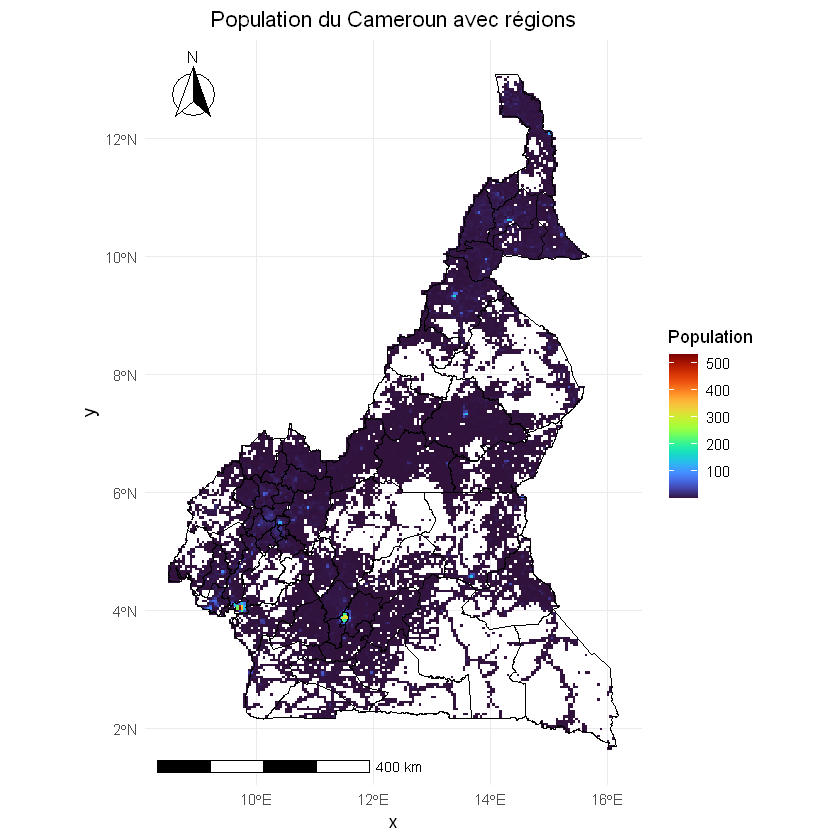

In [41]:
pop_df <- data.frame(rasterToPoints(pop_child), stringsAsFactors = FALSE)
colnames(pop_df) <- c("x", "y", "value")
ggplot() +
  geom_tile(data = pop_df, aes(x = x, y = y, fill = value)) +
  geom_sf(data = departement, fill = NA, color = "black", size = 0.5) +  # Ajouter les contours des régions
  scale_fill_viridis(option = "turbo", na.value = "transparent") +
  labs(title = "Population du Cameroun avec régions",
       fill = "Population") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "right"
  )+ 
  annotation_north_arrow(location = "tl", which_north = "true", pad_x = unit(0.1, "in"), pad_y = unit(0.1, "in"), style = north_arrow_fancy_orienteering()) + 
  annotation_scale(location = "bl", width_hint = 0.5)

<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  7. Rasters binarisés à partir de celui du taux de malaria</h2>

### Utilisation du resampling...avec la méthode des plus rpoches voisins (ngb)

In [ ]:
## On aligne les rasters suivant celui de la population

# Raster des situations (1, 2, 3)
malaria_2022_CMR_1 <- resample(malaria_2022_CMR, pop_child, method = "ngb")

# Raster des taux en 2022
taux_2022_1 <- resample(taux_2022, pop_child, method = "ngb")

In [ ]:
# Nombre d'enfants "par situation" (atteints ou non)
aucun <- calc(malaria_2022_CMR_1 == 1, fun = function(x) { ifelse(x, 1, 0) })*pop_child
moyen <- calc(malaria_2022_CMR_1 == 2, fun = function(x) { ifelse(x, 1, 0) })*pop_child
grave <- calc(malaria_2022_CMR_1 == 3, fun = function(x) { ifelse(x, 1, 0) })*pop_child

In [ ]:
# Nombre d'enfants atteints par situation
pop_aucun  <- aucun*taux_2022_1
pop_moyen  <- moyen*taux_2022_1
pop_grave  <- grave*taux_2022_1

<p style="font-size:25px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Calculons le nombre d'enfants atteints par situation</p>

In [221]:
A <-  sum(values(pop_aucun), na.rm = TRUE)
B <- sum(values(pop_moyen), na.rm = TRUE)
C <-  sum(values(pop_grave), na.rm = TRUE) 


t1 <- data.frame(
    situation_aucun = c(A, A*100/(A+B+C)),
    situation_moyen = c(B, B*100/(A+B+C)),
    situation_grave = c(C, C*100/(A+B+C)),
   somme =  c( A+B+C, A*100/(A+B+C)+ B*100/(A+B+C)+ C*100/(A+B+C))
    )
t1

# kable(t1)

situation_aucun,situation_moyen,situation_grave,somme
<dbl>,<dbl>,<dbl>,<dbl>
5106.9328,506.40287,306.064302,5919.4
86.2745,8.55497,5.170529,100.0


In [223]:
## Vérifications...

# Raster ayant toute la population malade
pop_malaria <- pop_child* resample(taux_2022, pop_child, method = "ngb")
enf_malades <- sum(values(pop_malaria), na.rm = TRUE) 

data.frame(total_enfants_malades = enf_malades ) %>% t()

total_enfants_malades,5933.623


<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">  8. Nombre d'enfants atteints par admin </h2>

In [226]:
pop_cameroun$pop_malade <- exact_extract(pop_malaria, cameroun, fun = "sum", progress = FALSE)

pop_region$pop_malade <- exact_extract(pop_malaria, region, fun = "sum", progress = FALSE) 

pop_departement$pop_malade <- exact_extract(pop_malaria, departement, fun = "sum", progress = FALSE) 

pop_arrondissement$pop_malade  <- exact_extract(pop_malaria, arrondissement, fun = "sum", progress = FALSE) 

# Exporter chaque data frame sous format CSV
#write.csv(pop_cameroun, file.path(output_folder, "cameroun.csv"), row.names = FALSE)
#write.csv(pop_region, file.path(output_folder, "region_cmr.csv"), row.names = FALSE)
#write.csv(pop_departement, file.path(output_folder, "departement_cmr.csv"), row.names = FALSE)
#write.csv(pop_arondissement, file.path(output_folder, "arondissement_cmr.csv"), row.names = FALSE)

In [180]:
head(pop_arrondissement,10)

,ADM3_FR,population,pop_malade,taux_malade
,<chr>,<dbl>,<dbl>,<dbl>
1,Abong-Mbang,40934.281,7.595561,0.1954352
2,Afanloum,3442.716,1.630748,0.5809367
3,Ako,33204.461,9.833481,0.3011644
4,Akoeman,8750.636,3.749373,0.4571096
5,Akom 2,13346.139,5.678644,0.4495682
6,Akono,13826.283,5.413332,0.3616301
7,Akonolinga,77040.172,26.947571,0.3504665
8,Akwaya,35409.289,10.549787,0.3106529
9,Alou,17685.900,3.154735,0.1696266


In [229]:
# Vérifications

t2 <- data.frame(
     enfts_malades_cameroun = sum(pop_cameroun$pop_malade),
    enfts_malades_region = sum(pop_region$pop_malade),
     enfts_malades_departements=sum(pop_departement$pop_malade),
     enfts_malades_arrondissements=sum(pop_arrondissement$pop_malade)) %>% t()

t2

enfts_malades_cameroun,5909.672
enfts_malades_region,5909.673
enfts_malades_departements,5909.673
enfts_malades_arrondissements,5909.673


<h2 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;"> 9. Taux d'enfants atteints par admin </h2>

In [230]:
## On prend la population malade sur celle totale d'enfants et le tout * 100
# taux = nb atteints dans l'admin / nb total

pop_cameroun$taux_malade <- pop_cameroun$pop_malade/(pop_cameroun$population*0.001)

pop_region$taux_malade <- pop_region$pop_malade/(pop_region$population*0.001)

pop_departement$taux_malade <- pop_departement$pop_malade/(pop_departement$population*0.001)
 
pop_arrondissement$taux_malade  <- pop_arrondissement$pop_malade/(pop_arrondissement$population*0.001)

In [231]:
head(pop_arrondissement,10)

,ADM3_FR,population,pop_malade,taux_malade
,<chr>,<dbl>,<dbl>,<dbl>
1,Abong-Mbang,40934.281,11.730131,0.2865601
2,Afanloum,3442.716,1.559191,0.4528957
3,Ako,33204.461,9.463091,0.2849946
4,Akoeman,8750.636,3.749743,0.4285109
5,Akom 2,13346.139,5.935190,0.4447121
6,Akono,13826.283,5.929521,0.4288586
7,Akonolinga,77040.172,26.515779,0.3441812
8,Akwaya,35409.289,9.439878,0.2665933
9,Alou,17685.900,2.812248,0.1590107


___________

<h2 style="text-align:center; background-color:RGB(255,165,0);font-size:45px;font-family:Algerian"> Fin du script</h2>